In [1]:
# Let's find some good sparse features we like.

%load_ext autoreload
%autoreload 2

import os

os.environ['HUGGINGFACE_HUB_CACHE'] = '/scratch/gsk6me/huggingface_cache'


In [2]:
import torch
import blobfile as bf
import transformer_lens
import sparse_autoencoder

# Load the autoencoders
autoencoders = []

for layer_index in range(12):
    print("Loading", layer_index)
    autoencoder_input = ["mlp_post_act", "resid_delta_mlp"][0]
    filename = f"az://openaipublic/sparse-autoencoder/gpt2-small/{autoencoder_input}/autoencoders/{layer_index}.pt"
    with bf.BlobFile(filename, mode="rb", streaming=False, cache_dir='/scratch/gsk6me/sae-gpt2-small-cache') as f:
        state_dict = torch.load(f)
    autoencoder = sparse_autoencoder.Autoencoder.from_state_dict(state_dict)
    autoencoders.append(autoencoder.to('cuda'))


Loading 0
Loading 1
Loading 2
Loading 3
Loading 4
Loading 5
Loading 6
Loading 7
Loading 8
Loading 9
Loading 10
Loading 11


In [3]:
import datasets

dataset_iterable = datasets.load_dataset("monology/pile-uncopyrighted", streaming=True)


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

In [4]:
model = transformer_lens.HookedTransformer.from_pretrained("gpt2", center_writing_weights=False)

Loaded pretrained model gpt2 into HookedTransformer


In [5]:
@torch.no_grad()
def get_sparse_features(prompt):
    tokens = model.to_tokens(prompt)  # (1, n_tokens)
    # print(model.to_str_tokens(tokens))
    logits, activation_cache = model.run_with_cache(tokens, remove_batch_dim=True)
        
    # Encode neuron activations with the autoencoder
    device = next(model.parameters()).device

    latent_activations = []
    for autoencoder in autoencoders:
        if autoencoder_input == "mlp_post_act":
            input_tensor = activation_cache[f"blocks.{layer_index}.mlp.hook_post"]  # (n_tokens, n_neurons)
        elif autoencoder_input == "resid_delta_mlp":
            input_tensor = activation_cache[f"blocks.{layer_index}.hook_mlp_out"]  # (n_tokens, n_residual_channels)

        # (n_tokens, n_latents)
        latent_activations.append(autoencoder.encode(input_tensor))
        
    del activation_cache
    
    return (tokens, torch.stack(latent_activations, dim=0))

In [6]:
class ActivationCache:
    def __init__(self, n_layers, n_features, top_k=100, window_size=16):
        self.cutoffs = torch.zeros((n_layers, n_features), device='cuda')
        self.top_k = top_k
        self.highest = {}
        self.window_size = window_size
        
    def update_helper(self, layer, feature, activation, window_tokens):
        # returns the new cutoff if it needs to be made
        index_name = f"{layer}.{feature}"
        if index_name not in self.highest:
            self.highest[index_name] = []
        # find insertion point. i = number of values we were >=.
        # highest is sorted in ascending order.
        i = 0
        while i < len(self.highest[index_name]):
            compare_act = self.highest[index_name][i][0]
            if activation < compare_act:
                break
            i += 1
            
        rank = len(self.highest[index_name]) - i + 1
        if rank <= self.top_k:
            self.highest[index_name].insert(i, (activation, window_tokens))
        
        extra = len(self.highest[index_name]) - self.top_k
        if extra > 0:
            new_cutoff = self.highest[index_name][extra][0]
            self.highest[index_name] = self.highest[index_name][extra:]
        else:
            new_cutoff = self.cutoffs[layer, feature]
        return new_cutoff
        
    def update(self, activations, tokens, instance):
        best = activations.max(dim=1)
        to_update = (best.values > self.cutoffs)
        for (layer, feature) in torch.nonzero(to_update):
            # store a window of 16 tokens before, 16 tokens at/after
            index = best.indices[layer, feature]
            activation = best.values[layer, feature]
            window_start = max(0, index - self.window_size)
            window_end = min(len(tokens), window_start + self.window_size)
            window_tokens = tokens[window_start:window_end]
            
            self.cutoffs[layer, feature] = self.update_helper(layer, feature, activation, window_tokens)


In [ ]:
import time

start = time.time()
feats = get_sparse_features(instance['text'])
end = time.time()
print(end-start)

In [47]:
feats1 = feats[1].cuda()

In [49]:
highest = feats1.max(dim=1)

In [56]:
highest.indices.shape

torch.Size([12, 32768])

In [6]:
import tqdm

def infer_topic_sentences(topic):
    results = []

    sentences = open(f"example_sentences/{topic}.txt").read().split("\n")

    for i, text in enumerate(tqdm.tqdm(sentences, desc='Running inference')):
        tokens, feats = get_sparse_features(text)

        # Store all layers
        results.append((tokens.cpu(), feats.cpu()))
        
    return results

for topic in ['math', 'physics', 'chemistry']:
    torch.save(infer_topic_sentences(topic), f"example_sentences/{topic}_outputs.pt")

Running inference: 100%|██████████| 83/83 [00:03<00:00, 22.79it/s]


In [27]:
def infer_controlled_classification(ds='languages'):
    sentences = open(f"example_sentences/{ds}_controlled.txt").readlines()
    lines = [s.strip() for s in sentences]
    lines = [s for s in lines if len(s) > 0]
    results = {}
    for line in tqdm.tqdm(lines):
        sentiment, text = line.split(": ", 2)
        sentiment = sentiment[2:].lower()
        tokens, feats = get_sparse_features(text)
        # Store all layers
        result = tokens.cpu(), feats.cpu()
        if sentiment not in results:
            results[sentiment] = []
        results[sentiment].append(result)
    return results

torch.save(
    infer_controlled_classification('languages'),
    "example_sentences/languages_controlled_results.pt"
)
torch.save(
    infer_controlled_classification('sentiment'),
    "example_sentences/sentiment_controlled_results.pt"
)

100%|██████████| 410/410 [00:31<00:00, 12.93it/s]


In [8]:
from transformers import AutoModelForCausalLM, AutoTokenizer

gpt2 = AutoModelForCausalLM.from_pretrained("gpt2")
tokenizer = AutoTokenizer.from_pretrained("gpt2")


In [16]:
tokenizer.decode(
    gpt2.generate(**tokenizer("Why is water wet?", return_tensors='pt'), max_new_tokens=100)[0]
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Why is water wet?\n\nWater is a natural resource. It is a natural resource that is used to make food, clothing, and other goods. It is a natural resource that is used to make food, clothing, and other goods. It is a natural resource that is used to make food, clothing, and other goods. It is a natural resource that is used to make food, clothing, and other goods. It is a natural resource that is used to make food, clothing, and other goods. It is'

In [25]:
def generate_contextualized_dset():
    lines = open("example_sentences/contextualized.txt").readlines()
    lines = [s.strip() for s in lines]
    lines = [s for s in lines if len(s) > 0]
    counter = 0
    results = []
    
    while counter < len(lines):
        sentence_with_choice = lines[counter].split(". ", 2)[1]
        sentence, choice = sentence_with_choice.split("(", 2)
        sentence = sentence.strip()
        choice = choice.split(")")[0]
        choices = choice.split(", ")
        context_1 = lines[counter + 1].split(": ", 2)[1]
        context_2 = lines[counter + 2].split(": ", 2)[1]
        
        results.append(context_1 + " " + sentence + " " + choices[0])
        results.append(context_2 + " " + sentence + " " + choices[1])
        
        counter += 3
        
    return results

def infer_list(sentences):
    results = []

    for i, text in enumerate(tqdm.tqdm(sentences, desc='Running inference')):
        tokens, feats = get_sparse_features(text)

        # Store all layers
        results.append((tokens.cpu(), feats.cpu()))
        
    return results

contextualized_dset = generate_contextualized_dset()
import json
with open("example_sentences/contextualized.json", "w") as f:
    json.dump(contextualized_dset, f)
outputs = infer_list(contextualized_dset)
torch.save(outputs, "example_sentences/contextualized_outputs.pt")


Running inference: 100%|██████████| 296/296 [00:13<00:00, 22.13it/s]


In [ ]:
def infer_languages():
    sentences = open("example_sentences/languages.txt").readlines()
    lines = [s.strip() for s in sentences]
    lines = [s for s in lines if len(s) > 0]
    results = {}
    for line in lines:
        sentiment, text = line.split(": ", 2)
        sentiment = sentiment[2:].lower()
        tokens, feats = get_sparse_features(text)
        # Store all layers
        result = tokens.cpu(), feats.cpu()
        if sentiment not in results:
            results[sentiment] = []
        results[sentiment].append(result)
    return results

# Comparing Activations

We assess what happens in a language model for sentences of different sentiments.

In [40]:
results = torch.load("example_sentences/sentiment_controlled_results.pt")

In [102]:
# take mean 'neutral' activation
def get_mean_activation(results):
    s = torch.zeros_like(results[0][1].sum(dim=1), device='cuda')
    n = len(results)
    for i in range(len(results)):
        s += results[i][1].cuda().sum(dim=1)
        results[i][1].cpu()
    return s/n

neutral_mean = get_mean_activation(results['neutral'])
positive_mean = get_mean_activation(results['positive'])
negative_mean = get_mean_activation(results['negative'])

sentiment_means = {
    key: get_mean_activation(results[key]) for key in results.keys()
}

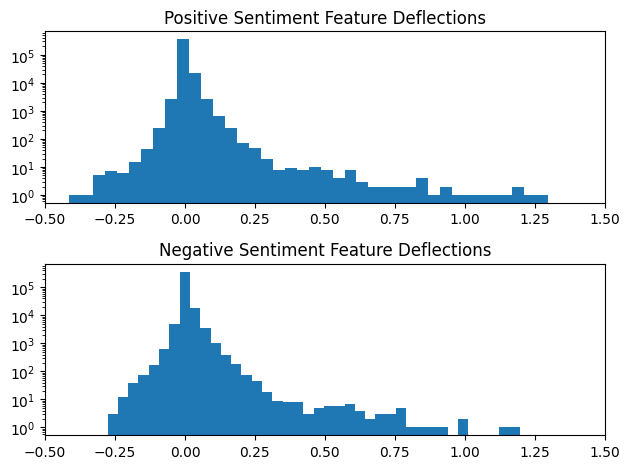

In [90]:
diff_positive = positive_mean - neutral_mean
diff_negative = negative_mean - neutral_mean

# flatten
diff_positive_flat = diff_positive.view(-1).cpu().numpy()
diff_negative_flat = diff_negative.view(-1).cpu().numpy()

# plot
import matplotlib.pyplot as plt
import numpy as np

plt.subplot(2, 1, 1)
plt.title("Positive Sentiment Feature Deflections")
plt.hist(diff_positive_flat, bins=40)
plt.yscale("log")
plt.xlim(-0.5, 1.5)
plt.subplot(2, 1, 2)
plt.title("Negative Sentiment Feature Deflections")
plt.hist(diff_negative_flat, bins=40)
plt.xlim(-0.5, 1.5)
plt.yscale("log")
plt.tight_layout()
plt.show()


## Assessing Language Classification

We generate a large (~500-sample) dataset of example sentences. The same sentence is translated into 5 languages to ensure that the comparison is as clean as possible.


In [64]:
lang_results = torch.load("example_sentences/languages_controlled_results.pt")

In [92]:
lang_means = {
    key: get_mean_activation(lang_results[key])
    for key in lang_results.keys()
}

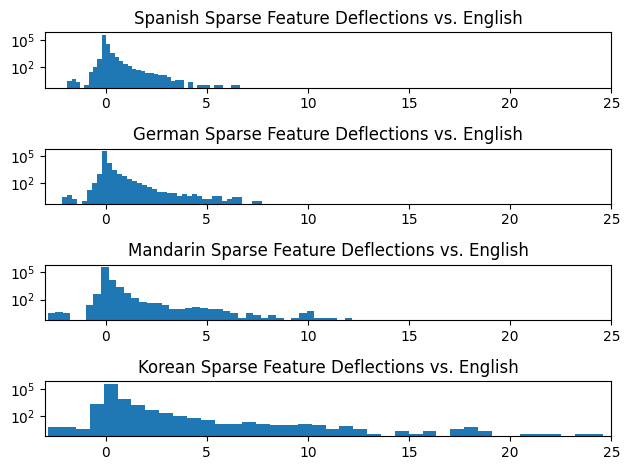

In [93]:
# see if there are any neurons that fire particularly for X language
counter = 0
for key in lang_results.keys():
    if key == 'english': continue
    other_mean = lang_means['english'] # torch.zeros_like(means[key])
    # for key_2 in lang_results.keys():
    #     other_mean += means[key_2]
    # other_mean /= (len(lang_results.keys()) - 1)
    
    # compare to other mean
    defl = (lang_means[key] - other_mean).view(-1).cpu().numpy()
    plt.subplot(4, 1, counter + 1)
    plt.title(key.title() + " Sparse Feature Deflections vs. English")
    plt.hist(defl, bins=40)
    plt.yscale("log")
    plt.xlim(-3, 25)
    counter += 1
plt.tight_layout()
plt.show()

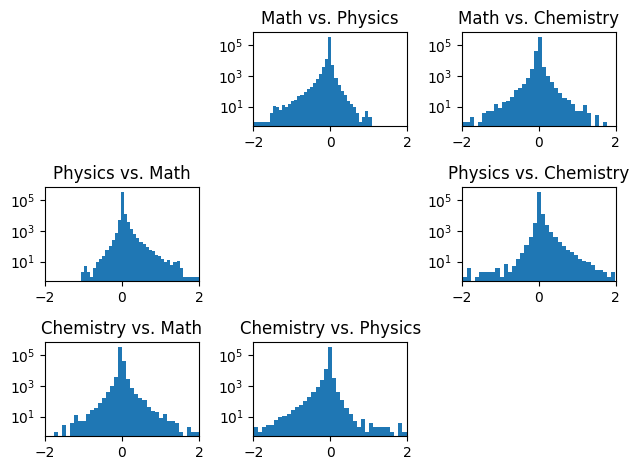

In [85]:
# find means for different topic areas like math, physics, and chemistry
topic_results = {
    'math': torch.load("example_sentences/math_outputs.pt"),
    'physics': torch.load("example_sentences/physics_outputs.pt"),
    'chemistry': torch.load("example_sentences/chemistry_outputs.pt"),
}
topic_means = {
    key: get_mean_activation(topic_results[key]) for key in topic_results.keys()
}

# see if there are any neurons that fire particularly for X topic area
topic_keys = ['math', 'physics', 'chemistry']
for i in range(len(topic_keys)):
    for j in range(len(topic_keys)):
        if i == j:
            continue
            
        key = topic_keys[i]
        other_key = topic_keys[j]
        
        plt.subplot(3, 3, i * 3 + j + 1)
        plt.title(key.title() + " vs. " + other_key.title())
        
        # compare to other mean
        defl = (topic_means[key] - topic_means[other_key]).view(-1).cpu().numpy()
        plt.hist(defl, bins=40)
        plt.xlim(-2, 2)
        plt.yscale("log")
plt.tight_layout()
plt.show()

## Visualizing Knowledge Locality (by layer)

Which layers have the most difference in activation by subject? Maybe this can provide clues on where knowledge is localized, if it is specific by layer at all.


In [105]:
def compare_layerwise_activations(control, compare, lower, upper):
    defl = compare - control
    
    for layer in range(12):
        layer_defl = defl[layer]
        plt.subplot(4, 3, layer + 1)
        plt.title("Layer " + str(layer + 1))
        plt.hist(layer_defl.cpu().numpy(), bins=40)
        plt.yscale('log')
        plt.xlabel("Deflection")
        plt.xlim(lower, upper)
    plt.tight_layout()
    plt.show()

Spanish comparison


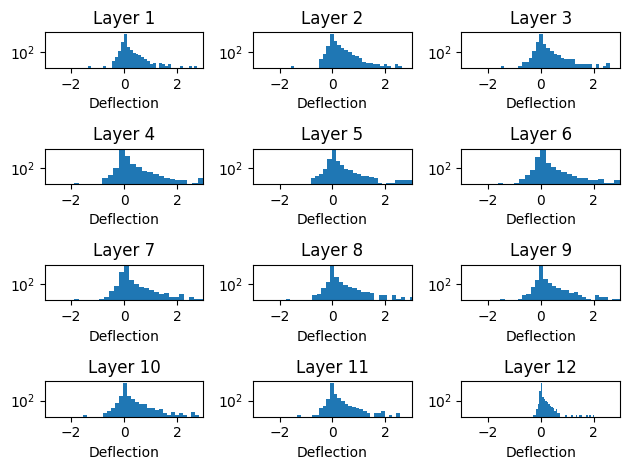

German comparison


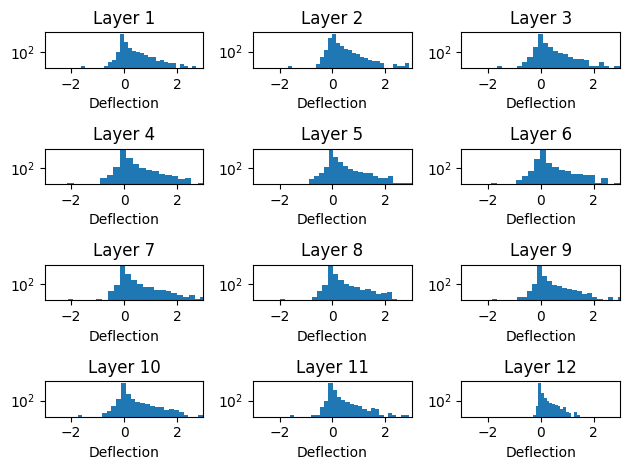

Mandarin comparison


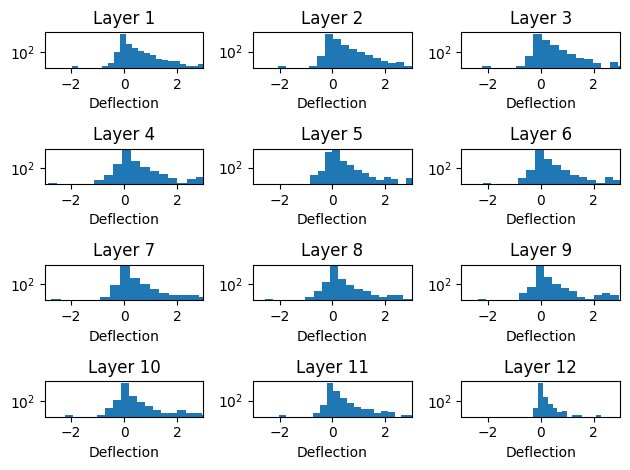

Korean comparison


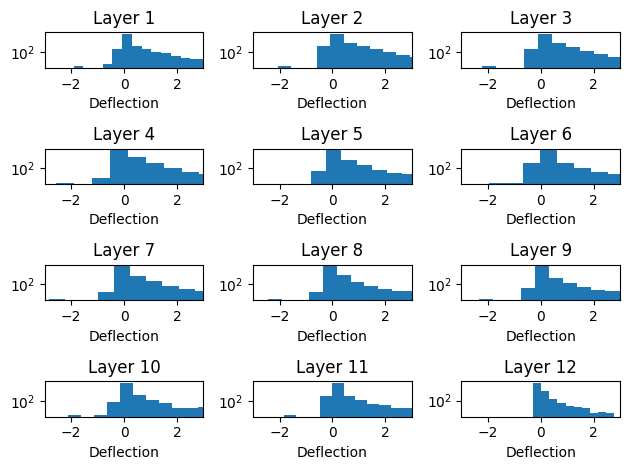

In [98]:
for other in ['spanish', 'german', 'mandarin', 'korean']:
    print(other.title(), "comparison")
    compare_layerwise_activations(
        lang_means['english'],
        lang_means[other],
        -3, 3
    )

Positive comparison


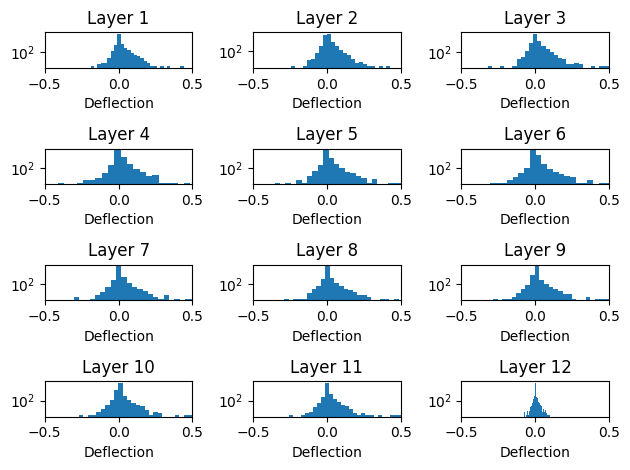

Negative comparison


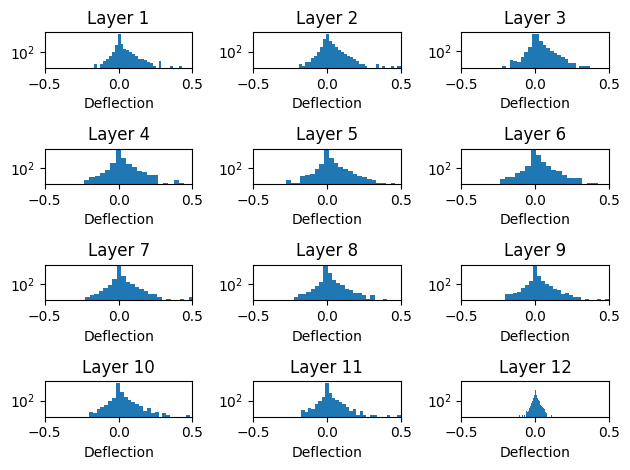

In [106]:
for other in ['positive', 'negative']:
    print(other.title(), "comparison")
    compare_layerwise_activations(
        sentiment_means['neutral'],
        sentiment_means[other],
        -0.5, 0.5
    )


In [7]:
# Extract neuron activations with transformer_lens
model = transformer_lens.HookedTransformer.from_pretrained("gpt2", center_writing_weights=False)
prompt = "Exploring SLAM techniques to allow for racecar to better perceive its position in relation to the environment. Working on improving route planning for racecar throughout the track."
tokens = model.to_tokens(prompt)  # (1, n_tokens)
print(model.to_str_tokens(tokens))
with torch.no_grad():
    logits, activation_cache = model.run_with_cache(tokens, remove_batch_dim=True)

latent_activations = []
for autoencoder in autoencoders:
    if autoencoder_input == "mlp_post_act":
        input_tensor = activation_cache[f"blocks.{layer_index}.mlp.hook_post"]  # (n_tokens, n_neurons)
    elif autoencoder_input == "resid_delta_mlp":
        input_tensor = activation_cache[f"blocks.{layer_index}.hook_mlp_out"]  # (n_tokens, n_residual_channels)

    # Encode neuron activations with the autoencoder
    device = next(model.parameters()).device
    autoencoder.to(device)
    with torch.no_grad():
        acts = autoencoder.encode(input_tensor)  # (n_tokens, n_latents)
        latent_activations.append(acts)

Loaded pretrained model gpt2 into HookedTransformer
['<|endoftext|>', 'Expl', 'oring', ' SL', 'AM', ' techniques', ' to', ' allow', ' for', ' race', 'car', ' to', ' better', ' perceive', ' its', ' position', ' in', ' relation', ' to', ' the', ' environment', '.', ' Working', ' on', ' improving', ' route', ' planning', ' for', ' race', 'car', ' throughout', ' the', ' track', '.']


In [20]:
import matplotlib.pyplot as plt
import neuron_visualization
from IPython.display import display, HTML

for layer_id in range(12):
    acts = latent_activations[layer_id]
    top_feature = acts.max(dim=0)[0].argmax().item()
    print("Layer", layer_id)
    display(HTML(neuron_visualization.basic_neuron_vis_signed(model.to_str_tokens(tokens), acts[:, top_feature], 1)))


Layer 0


Layer 1


Layer 2


Layer 3


Layer 4


Layer 5


Layer 6


Layer 7


Layer 8


Layer 9


Layer 10


Layer 11
